In [1]:
# Package imports
from behavior_mapper import helper_functions, activities_class, modeling
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Data prep
sample_input = helper_functions.csv_import(file='data/private/jds_tt_eventdetail.csv',
                                          ID='uuid',
                                          activity='event_name',
                                          timestamp_col='event_datetime')

activities_df = activities_class.activities({'ID':sample_input['uuid'],
                                            'activity':sample_input['event_name'],
                                            'occurrence':sample_input['event_datetime']})

sequence_df, activity_map, activity_counts = activities_df.create_corpus(drop_activities=['insweb.entry','insweb.exit'],
                                                                         min_num=2, 
                                                                         remove_repeats=True)

In [2]:
def comparison_metrics(sequence_df, activity_map, activity_counts,
                      sample, cluster_dims, eps):
    
    # Skip grams and dimension reduction
    activities_features = modeling.fit_sequences(sequence_df=sequence_df,
                                                 activity_map=activity_map,
                                                 feature_size=100,
                                                 window=4,
                                                 min_activity_count=0,
                                                 iter=50,
                                                 sample=sample)

    activity_cluster_df = modeling.dim_reduction(activities_features)
    
    # Add count for volume
    activity_cluster_df = modeling.add_counts(activity_cluster_df,
                                             activity_counts)
    
    # Cluster
    activity_cluster_df = modeling.dbscan_cluster (activity_cluster_df,
                                                   cluster_dims=cluster_dims,
                                                   min_samples=3,
                                                   eps=eps) 
    
    # Assessment
    cluster_no = activity_cluster_df['cluster'].max() + 1 # Number of clusters
    med_cluster = activity_cluster_df.loc[activity_cluster_df.cluster >= 0].groupby('cluster')['x'].count().median() # Median activities per cluster
    noise_points = len(activity_cluster_df.loc[activity_cluster_df.cluster == -1]) # Activities classified as noise
    clustered_points = len(activity_cluster_df.loc[activity_cluster_df.cluster >= 0]) # Activities clustered as not noise
    sil_score = silhouette_score(activity_cluster_df[cluster_dims], activity_cluster_df['cluster']) # Silhouette Score
    
    """
    print('Noise activities: {}'.format(noise_points))
    print('Clustered activities: {}'.format(clustered_points))
    print('Median activities per cluster: {}'.format(med_cluster))
    print('Mean activities per cluster: {}'.format(mean_cluster))
    print('Silhouette Score: {}'.format(sil_score))
    """
    return cluster_no, med_cluster, noise_points, clustered_points, sil_score
    
    

# Epsilon Value

In [4]:
clusters = []
med_act_per = []
noise_act = []
cluster_act = []
silhouette = []

eps_values = [.1, .5, 1, 2, 3, 4, 5, 7, 10]
for idx, eps_value in enumerate(eps_values):
    cluster_no, med_cluster, noise_points, clustered_points, sil_score = comparison_metrics(sequence_df, activity_map, activity_counts,
                                                                                           sample=1e-5, cluster_dims=['x','y'], eps=eps_value)
    clusters.insert(idx, cluster_no)
    med_act_per.insert(idx, med_cluster)
    noise_act.insert(idx, noise_points)
    cluster_act.insert(idx, clustered_points)
    silhouette.insert(idx, sil_score)

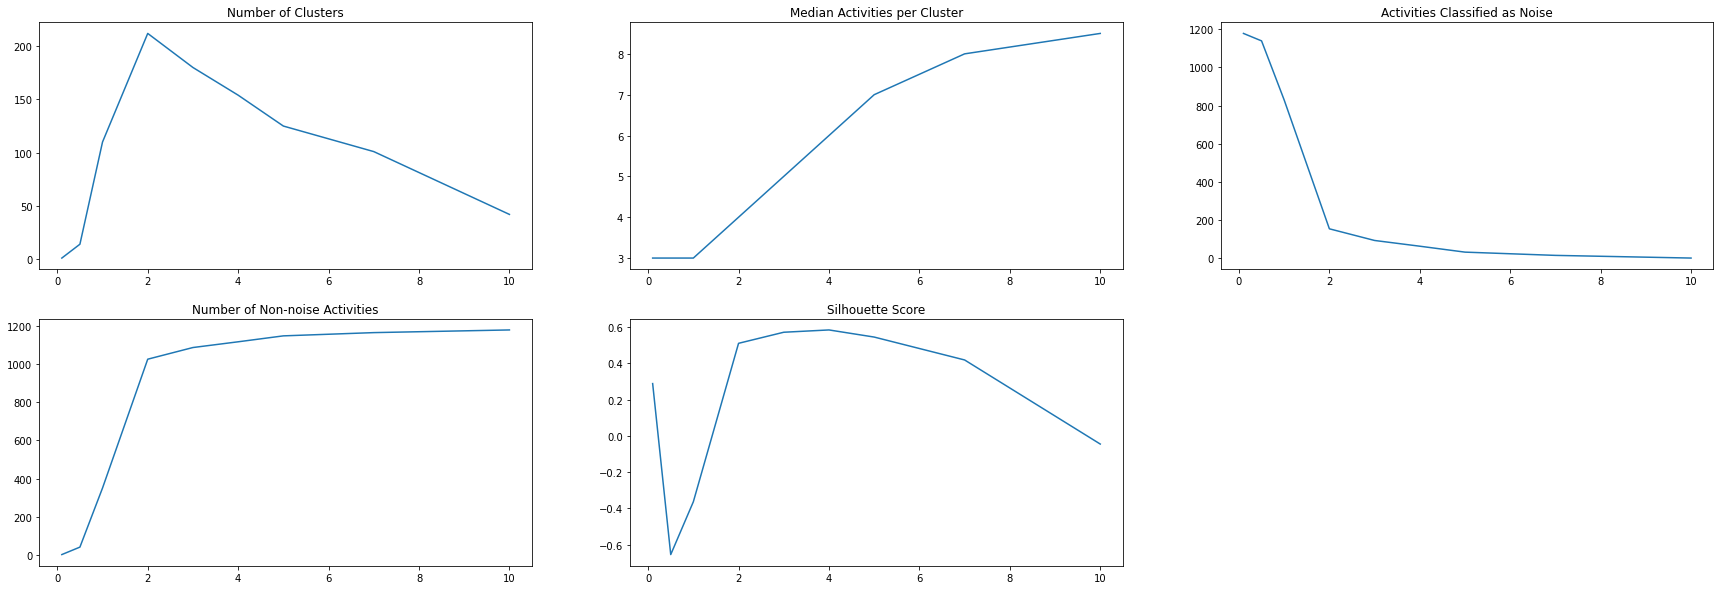

In [19]:
plt.figure(figsize=(30,10))
plt.subplot(2, 3, 1)
plt.title('Number of Clusters')
plt.plot(eps_values, clusters)

plt.subplot(2,3,2)
plt.title('Median Activities per Cluster')
plt.plot(eps_values, med_act_per)

plt.subplot(2,3,3)
plt.title('Activities Classified as Noise')
plt.plot(eps_values, noise_act)

plt.subplot(2,3,4)
plt.title('Number of Non-noise Activities')
plt.plot(eps_values, cluster_act)

plt.subplot(2,3,5)
plt.title('Silhouette Score')
plt.plot(eps_values, silhouette)

plt.show()

An epsilon value of 5 suggests a possible optimal elbow shape when examining the number of clusters produced. Similarly, it suggest a similar optimal point in terms of median activities per cluster. An epsilon value between 2 and 7 shows a relatively plateau-like shape for noise classification and silhouette score. Thus, an epsilon value of 5 seems to be a valid parameter value for this dataset. 

# Sub-sampling

In [24]:
clusters = []
med_act_per = []
noise_act = []
cluster_act = []
silhouette = []

sample_values = [0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for idx, sample_value in enumerate(sample_values):
    cluster_no, med_cluster, noise_points, clustered_points, sil_score = comparison_metrics(sequence_df, activity_map, activity_counts,
                                                                                           sample=sample_value, cluster_dims=['x','y'], eps=5)
    clusters.insert(idx, cluster_no)
    med_act_per.insert(idx, med_cluster)
    noise_act.insert(idx, noise_points)
    cluster_act.insert(idx, clustered_points)
    silhouette.insert(idx, sil_score)

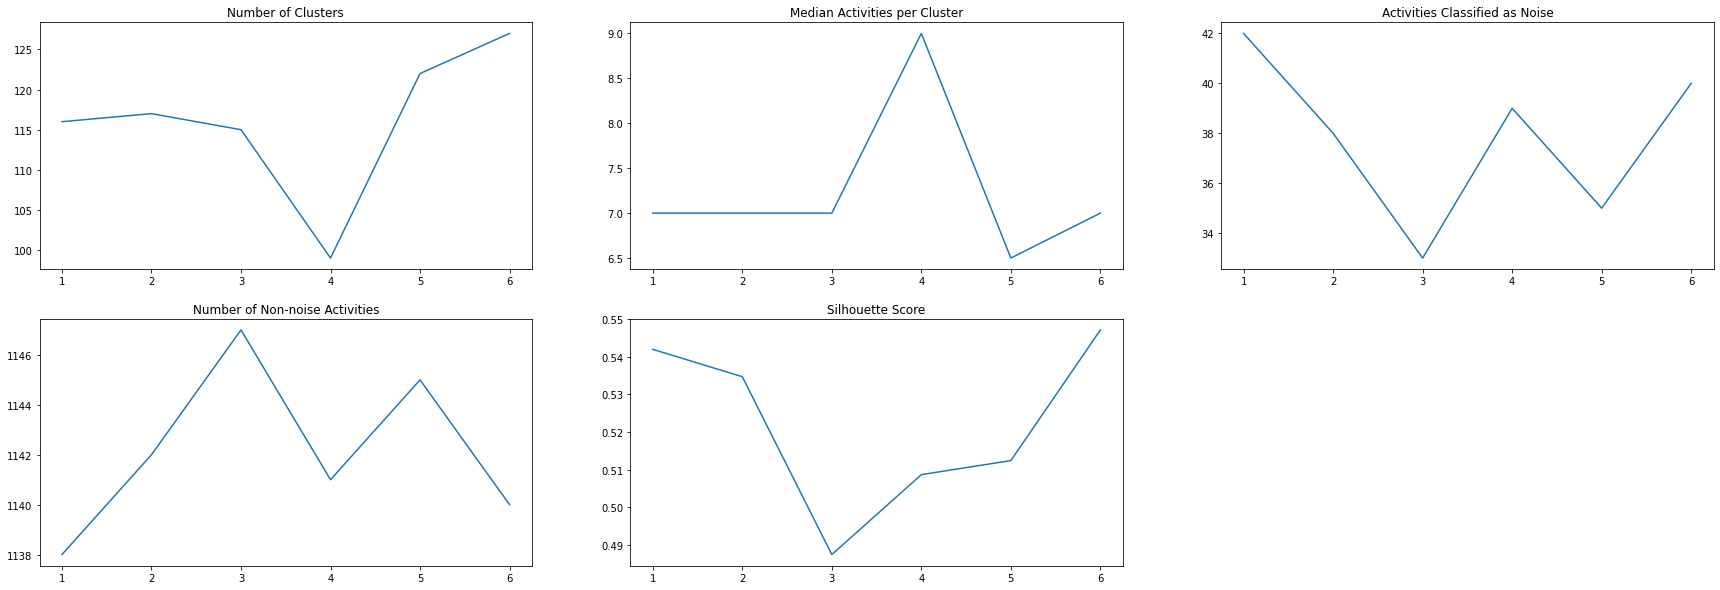

In [25]:
plt.figure(figsize=(30,10))
plt.subplot(2, 3, 1)
plt.title('Number of Clusters')
plt.plot(np.arange(1,7), clusters)

plt.subplot(2,3,2)
plt.title('Median Activities per Cluster')
plt.plot(np.arange(1,7), med_act_per)

plt.subplot(2,3,3)
plt.title('Activities Classified as Noise')
plt.plot(np.arange(1,7), noise_act)

plt.subplot(2,3,4)
plt.title('Number of Non-noise Activities')
plt.plot(np.arange(1,7), cluster_act)

plt.subplot(2,3,5)
plt.title('Silhouette Score')
plt.plot(np.arange(1,7), silhouette)

plt.show()

Subsampling does not have a profound impact on clustering nor silhouette score. Furthermore, based on typical website navigation and resulting clickstream data, there are activities or pages that will always be found, such as homepage or login. These make a case for the maximum amount of subsampling, which corresponds with the highest silhouette score. Thus, a subsampling value of 1e-5 is a valid parameter value.

# Negative Sampling

In [26]:
def comparison_metrics(sequence_df, activity_map, activity_counts,
                      sample, cluster_dims, eps, negative):
    
    # Skip grams and dimension reduction
    activities_features = modeling.fit_sequences(sequence_df=sequence_df,
                                                 activity_map=activity_map,
                                                 feature_size=100,
                                                 window=4,
                                                 min_activity_count=0,
                                                 iter=50,
                                                 sample=sample,
                                                 negative=negative)

    activity_cluster_df = modeling.dim_reduction(activities_features)
    
    # Add count for volume
    activity_cluster_df = modeling.add_counts(activity_cluster_df,
                                             activity_counts)
    
    # Cluster
    activity_cluster_df = modeling.dbscan_cluster (activity_cluster_df,
                                                   cluster_dims=cluster_dims,
                                                   min_samples=3,
                                                   eps=eps) 
    
    # Assessment
    cluster_no = activity_cluster_df['cluster'].max() + 1 # Number of clusters
    med_cluster = activity_cluster_df.loc[activity_cluster_df.cluster >= 0].groupby('cluster')['x'].count().median() # Median activities per cluster
    noise_points = len(activity_cluster_df.loc[activity_cluster_df.cluster == -1]) # Activities classified as noise
    clustered_points = len(activity_cluster_df.loc[activity_cluster_df.cluster >= 0]) # Activities clustered as not noise
    sil_score = silhouette_score(activity_cluster_df[cluster_dims], activity_cluster_df['cluster']) # Silhouette Score
    
    """
    print('Noise activities: {}'.format(noise_points))
    print('Clustered activities: {}'.format(clustered_points))
    print('Median activities per cluster: {}'.format(med_cluster))
    print('Mean activities per cluster: {}'.format(mean_cluster))
    print('Silhouette Score: {}'.format(sil_score))
    """
    return cluster_no, med_cluster, noise_points, clustered_points, sil_score

In [32]:
clusters = []
med_act_per = []
noise_act = []
cluster_act = []
silhouette = []

neg_samp_values = [0, 2, 5, 10, 15, 20]
for idx, neg_samp_value in enumerate(neg_samp_values):
    cluster_no, med_cluster, noise_points, clustered_points, sil_score = comparison_metrics(sequence_df, activity_map, activity_counts,
                                                                                           sample=1e-5, cluster_dims=['x','y'], eps=5, negative=neg_samp_value)
    clusters.insert(idx, cluster_no)
    med_act_per.insert(idx, med_cluster)
    noise_act.insert(idx, noise_points)
    cluster_act.insert(idx, clustered_points)
    silhouette.insert(idx, sil_score)

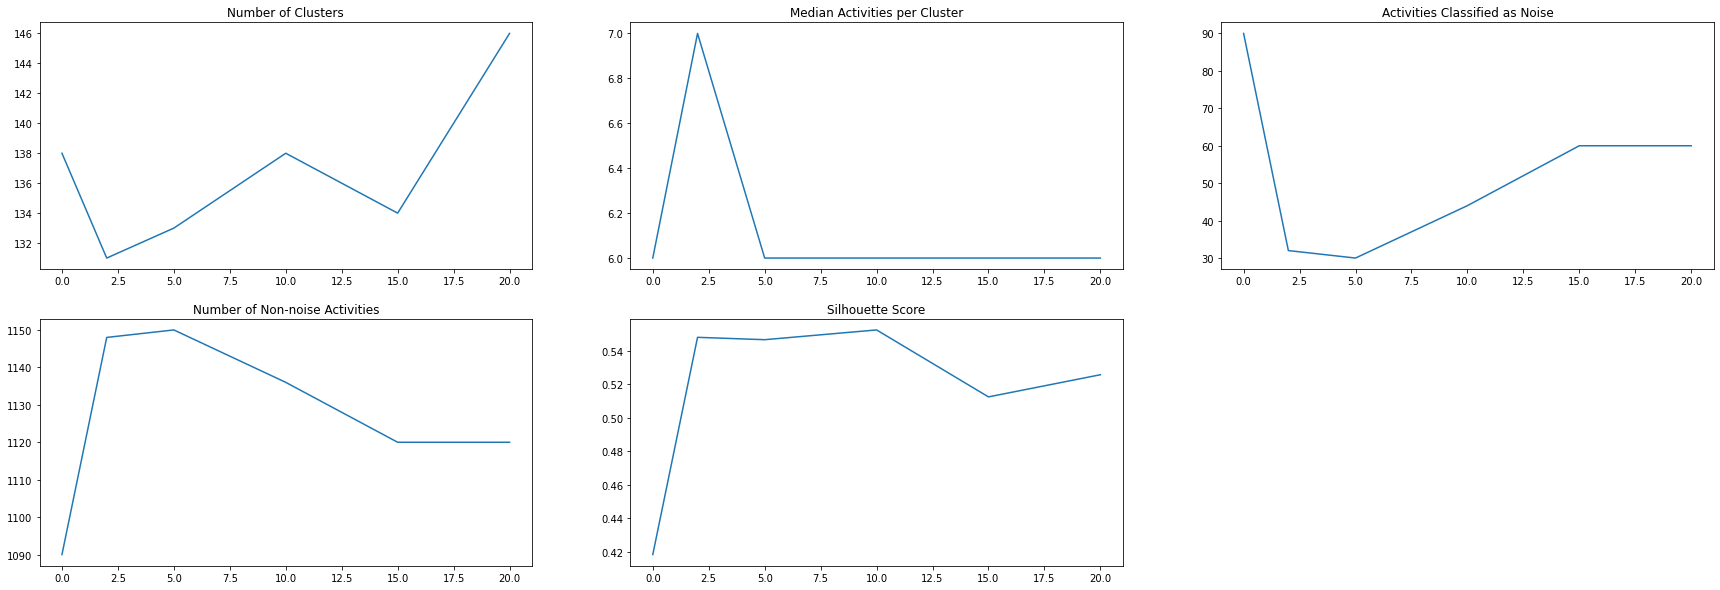

In [33]:
plt.figure(figsize=(30,10))
plt.subplot(2, 3, 1)
plt.title('Number of Clusters')
plt.plot(neg_samp_values, clusters)

plt.subplot(2,3,2)
plt.title('Median Activities per Cluster')
plt.plot(neg_samp_values, med_act_per)

plt.subplot(2,3,3)
plt.title('Activities Classified as Noise')
plt.plot(neg_samp_values, noise_act)

plt.subplot(2,3,4)
plt.title('Number of Non-noise Activities')
plt.plot(neg_samp_values, cluster_act)

plt.subplot(2,3,5)
plt.title('Silhouette Score')
plt.plot(neg_samp_values, silhouette)

plt.show()

Median activities per cluster seems to plateau after using 5 as the negative sampling value. The same value suggests suggests a valley in terms of classification as noise and is in the middle of the plateau of the silhouette score. Thus, 5 seems to be a valid value for specifiying how many non-similar activities should be used to compare to each activity vector. Furthermore, this should help with processing speed. 

# Evaluate if any benefit from using volume measure in Clustering

In [1]:
# Package imports
from behavior_mapper import helper_functions, activities_class, modeling
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 

# Data prep
sample_input = helper_functions.csv_import(file='data/private/jds_tt_eventdetail.csv',
                                          ID='uuid',
                                          activity='event_name',
                                          timestamp_col='event_datetime')

activities_df = activities_class.activities({'ID':sample_input['uuid'],
                                            'activity':sample_input['event_name'],
                                            'occurrence':sample_input['event_datetime']})

sequence_df, activity_map, activity_counts = activities_df.create_corpus(drop_activities=['insweb.entry','insweb.exit'],
                                                                         min_num=2, 
                                                                         remove_repeats=True)

In [12]:
def comparison_metrics(sequence_df, activity_map, activity_counts):
    
    # Skip grams and dimension reduction
    activities_features = modeling.fit_sequences(sequence_df=sequence_df,
                                                 activity_map=activity_map,
                                                 feature_size=100,
                                                 window=4,
                                                 min_activity_count=0,
                                                 iter=50,
                                                 sample=1e-5,
                                                 negative=5)

    activity_cluster_df = modeling.dim_reduction(activities_features)   
    
    # Add multiple volume metrics to compare impacts on clustering
    activity_cluster_df['volume'] = activity_cluster_df.index.map(activity_counts) # Absolute count of sessions
    activity_cluster_df['volume_log'] = np.log(activity_cluster_df['volume']) # Log of session count

    # Capture range of existing dimensions for consistent scaling
    min_value, max_value = activity_cluster_df['x'].min(),activity_cluster_df['x'].max()

    activity_cluster_df['volume_scaled_0_1'] = MinMaxScaler(feature_range=(0, 1)).fit_transform(activity_cluster_df['volume'].to_numpy().reshape(-1,1))

    activity_cluster_df['volume_scaled_min_max'] = MinMaxScaler(feature_range=(min_value, max_value)).fit_transform(activity_cluster_df['volume'].to_numpy().reshape(-1,1))
    
    return activity_cluster_df

In [13]:
cluster_eval_df = comparison_metrics(sequence_df, activity_map, activity_counts)

In [17]:
cluster_eval_df['volume_log'].describe()

count    1180.000000
mean        3.051072
std         2.247903
min         0.000000
25%         1.386294
50%         2.639057
75%         4.488636
max        11.057140
Name: volume_log, dtype: float64

In [54]:
def cluster_comparison(cluster_eval_df):   
    clusters = []
    med_act_per = []
    noise_act = []
    cluster_act = []
    silhouette = []

    vol_fields = ['remove','volume','volume_log','volume_scaled_0_1','volume_scaled_min_max']
    for idx, vol_field in enumerate(vol_fields):
        cluster_dims = ['x','y']
        cluster_dims.append(vol_field) # Add other field 
        if vol_field == 'remove':
            cluster_dims.pop(2)
        cluster_eval_df = modeling.dbscan_cluster (cluster_eval_df,
                                                       cluster_dims=cluster_dims,
                                                       min_samples=3,
                                                       eps=5) 

        cluster_no = cluster_eval_df['cluster'].max() + 1 # Number of clusters
        med_cluster = cluster_eval_df.loc[cluster_eval_df.cluster >= 0].groupby('cluster')['x'].count().median() # Median activities per cluster
        noise_points = len(cluster_eval_df.loc[cluster_eval_df.cluster == -1]) # Activities classified as noise
        clustered_points = len(cluster_eval_df.loc[cluster_eval_df.cluster >= 0]) # Activities clustered as not noise
        sil_score = silhouette_score(cluster_eval_df[cluster_dims], cluster_eval_df['cluster']) # Silhouette Score
        
        clusters.insert(idx, cluster_no)
        med_act_per.insert(idx, med_cluster)
        noise_act.insert(idx, noise_points)
        cluster_act.insert(idx, clustered_points)
        silhouette.insert(idx, sil_score)

    return clusters, med_act_per, noise_act, cluster_act, silhouette

clusters, med_act_per, noise_act, cluster_act, silhouette = cluster_comparison(cluster_eval_df)

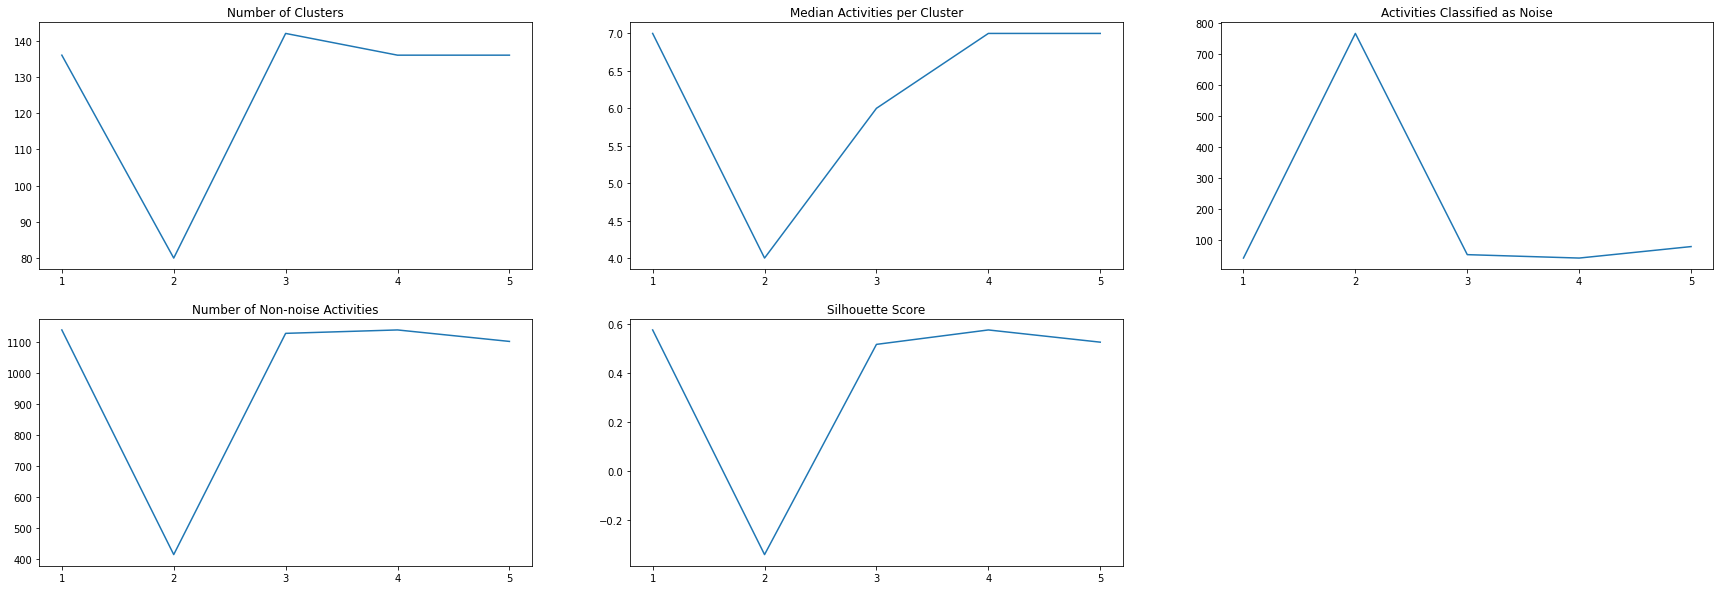

In [59]:
plt.figure(figsize=(30,10))
plt.subplot(2, 3, 1)
plt.title('Number of Clusters')
plt.plot(np.arange(1,6), clusters)
plt.xticks(np.arange(1,6))

plt.subplot(2,3,2)
plt.title('Median Activities per Cluster')
plt.plot(np.arange(1,6), med_act_per)
plt.xticks(np.arange(1,6))

plt.subplot(2,3,3)
plt.title('Activities Classified as Noise')
plt.plot(np.arange(1,6), noise_act)
plt.xticks(np.arange(1,6))

plt.subplot(2,3,4)
plt.title('Number of Non-noise Activities')
plt.plot(np.arange(1,6), cluster_act)
plt.xticks(np.arange(1,6))

plt.subplot(2,3,5)
plt.title('Silhouette Score')
plt.plot(np.arange(1,6), silhouette)
plt.xticks(np.arange(1,6))

plt.show()

As suspected, absolute volume renders extreme values that overpower any clustering from the 2 other dimensions provided by skip-grams. Next, this value will be removed to further compare the remainders.

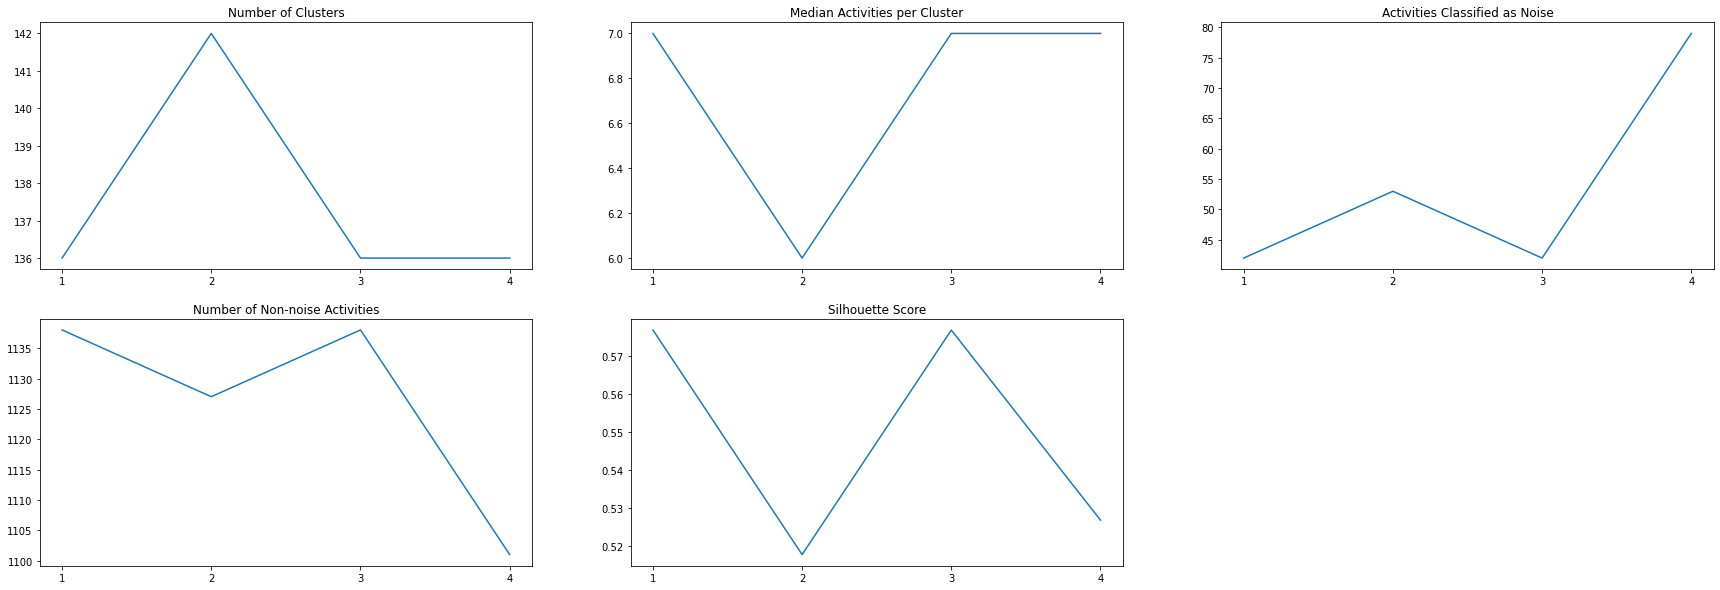

In [60]:
for result_list in [clusters, med_act_per, noise_act, cluster_act, silhouette]:
    result_list.pop(1)
    
plt.figure(figsize=(30,10))
plt.subplot(2, 3, 1)
plt.title('Number of Clusters')
plt.plot(np.arange(1,5), clusters)
plt.xticks(np.arange(1,5))

plt.subplot(2,3,2)
plt.title('Median Activities per Cluster')
plt.plot(np.arange(1,5), med_act_per)
plt.xticks(np.arange(1,5))

plt.subplot(2,3,3)
plt.title('Activities Classified as Noise')
plt.plot(np.arange(1,5), noise_act)
plt.xticks(np.arange(1,5))

plt.subplot(2,3,4)
plt.title('Number of Non-noise Activities')
plt.plot(np.arange(1,5), cluster_act)
plt.xticks(np.arange(1,5))

plt.subplot(2,3,5)
plt.title('Silhouette Score')
plt.plot(np.arange(1,5), silhouette)
plt.xticks(np.arange(1,5))

plt.show()

remove | volume_log | volume_scaled_0_1 | volume_scaled_min_max

Clustering with no volume or volume scaled between 0 and 1 suggest very similar results with comparable silhouette scores. The other 2 dimensions in this dataset range from -110 to 110. Thus, seeing similar separation from no volume metric versus a very low scaled value for volume suggests that inclusion of volume has little to no affect. At this point, volume will be captured (perhaps as % of sessions) but no suggested for clustering.

# Any Improvement with Using Percentiles in place of Volume

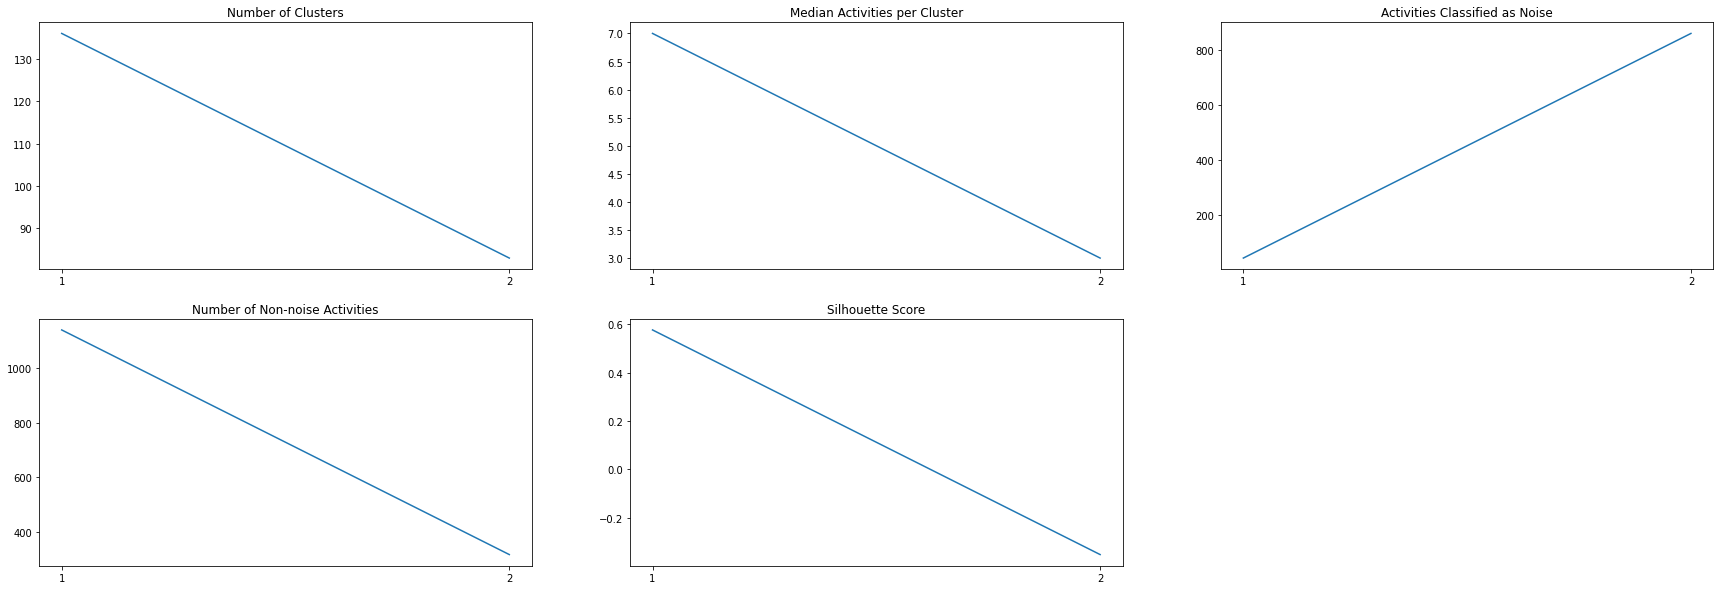

In [77]:
import pandas as pd
cluster_eval_df['volume'] = cluster_eval_df.index.map(activity_counts) 
cluster_eval_df['volume_pctl'] = cluster_eval_df['volume'].rank(pct=True)* 100

def cluster_comparison(cluster_eval_df):   
    clusters = []
    med_act_per = []
    noise_act = []
    cluster_act = []
    silhouette = []

    vol_fields = ['remove','volume_pctl']
    for idx, vol_field in enumerate(vol_fields):
        cluster_dims = ['x','y']
        cluster_dims.append(vol_field) # Add other field 
        if vol_field == 'remove':
            cluster_dims.pop(2)
        cluster_eval_df = modeling.dbscan_cluster (cluster_eval_df,
                                                       cluster_dims=cluster_dims,
                                                       min_samples=3,
                                                       eps=5) 

        cluster_no = cluster_eval_df['cluster'].max() + 1 # Number of clusters
        med_cluster = cluster_eval_df.loc[cluster_eval_df.cluster >= 0].groupby('cluster')['x'].count().median() # Median activities per cluster
        noise_points = len(cluster_eval_df.loc[cluster_eval_df.cluster == -1]) # Activities classified as noise
        clustered_points = len(cluster_eval_df.loc[cluster_eval_df.cluster >= 0]) # Activities clustered as not noise
        sil_score = silhouette_score(cluster_eval_df[cluster_dims], cluster_eval_df['cluster']) # Silhouette Score
        
        clusters.insert(idx, cluster_no)
        med_act_per.insert(idx, med_cluster)
        noise_act.insert(idx, noise_points)
        cluster_act.insert(idx, clustered_points)
        silhouette.insert(idx, sil_score)

    return clusters, med_act_per, noise_act, cluster_act, silhouette

clusters, med_act_per, noise_act, cluster_act, silhouette = cluster_comparison(cluster_eval_df)

plt.figure(figsize=(30,10))
plt.subplot(2, 3, 1)
plt.title('Number of Clusters')
plt.plot(np.arange(1,3), clusters)
plt.xticks(np.arange(1,3))

plt.subplot(2,3,2)
plt.title('Median Activities per Cluster')
plt.plot(np.arange(1,3), med_act_per)
plt.xticks(np.arange(1,3))

plt.subplot(2,3,3)
plt.title('Activities Classified as Noise')
plt.plot(np.arange(1,3), noise_act)
plt.xticks(np.arange(1,3))

plt.subplot(2,3,4)
plt.title('Number of Non-noise Activities')
plt.plot(np.arange(1,3), cluster_act)
plt.xticks(np.arange(1,3))

plt.subplot(2,3,5)
plt.title('Silhouette Score')
plt.plot(np.arange(1,3), silhouette)
plt.xticks(np.arange(1,3))

plt.show()

The clustering is significantly worsened by using an indication of percentile. A similar feature may be beneficial with other clustering methodologies. However, based on the significant level of interpretability that will be required for business users of the final product, volume will be excluded from DBSCAN clustering at this time. A percentile volume field will be included in the dataset however for additional usage, such as visualization sizing or user-determined clustering alternatives